# Group 70: Project Proposal
## Predicting Cancer Mortality Rates Through Varying Demographic Data

### Introduction
Cancer is one of the leading causes of death in the developed world. Therefore, it is crucial that we investigate the links between cancer mortality rates and demographic data. Using a dataset imported from data.world that aggregates data from the American Community Survey, clinicaltrails.gov (a public clinical trial database), and the National Cancer Institute, we hope to predict the cancer mortality rate of a county using demographic data. Our question is the following: given up to 5 predictors taken from demographic data in a certain county in the United States, what will be the cancer mortality rate of that county? The predictors were determined using the regsubsets() function in R, specified in the methodology, and their relevance was further supported by prior research (cited below) that demonstrates a significant relationship between the predictors and their implications on cancer mortality rates.




### Methodology

We start our analysis by installing and loading all necessary R packages required for our report.

In [47]:
#Loading libraries

install.packages(c("leaps"))

library(tidyverse) # to perform operations on the data set
library(repr) # to set graph plot size and performing some operations on data set
library(tidymodels)
library(leaps)
library(GGally) #to make graph using ggpairs() 
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Reading data from URL
To prepare our data for analysis, we started out with downloading the dataset from the web and publishing the data on our group GitHub. We then pulled the dataset and read it on Jupyter using a URL.

We also set a seed value to ensure that our code is reproducible.

In [48]:
# Reading the training data set from the Web into R
url <- "https://raw.githubusercontent.com/mimilht/dsci100-proj-group70/main/cancer_reg.csv"
cancer <- read_csv(url)
head(cancer)

set.seed(100) #setting seed value

Rows: 3047 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): binnedInc, Geography
dbl (32): avgAnnCount, avgDeathsPerYear, TARGET_deathRate, incidenceRate, me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,⋯,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1397,469,164.9,489.8,61898,260131,11.2,499.74820,"(61494.5, 125635]",39.3,⋯,NA,41.6,32.9,14.0,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831
173,70,161.3,411.6,48127,43269,18.6,23.11123,"(48021.6, 51046.4]",33.0,⋯,53.8,43.6,31.1,15.3,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096
102,50,174.7,349.7,49348,21026,14.6,47.56016,"(48021.6, 51046.4]",45.0,⋯,43.5,34.9,42.1,21.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488
427,202,194.8,430.4,44243,75882,17.1,342.63725,"(42724.4, 45201]",42.8,⋯,40.3,35.0,45.3,25.0,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841
57,26,144.4,350.1,49955,10321,12.5,0.00000,"(48021.6, 51046.4]",48.3,⋯,43.9,35.1,44.0,22.7,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657
428,152,176.0,505.4,52313,61023,15.6,180.25990,"(51046.4, 54545.6]",45.4,⋯,38.8,32.6,43.2,20.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476


### Cleaning and Wrangling Data into Tidydata Format

We then remove the missing data from our columns by removing the N/A fields.

The dataset required minimal cleaning as the data was in a relatively tidy format, and there wasn’t any metadata attached in the file nor was there any mismatch of rows and columns.


In [49]:
cancer_data <- cancer |> filter(na.rm = TRUE)
colSums(!is.na(cancer)) #counting number of observations in our columns (excluding n/a)

cancer_filter <- cancer_data |> select(-PctPrivateCoverageAlone, 
                                       -PctSomeCol18_24, -Geography, -avgAnnCount,
                                      -avgDeathsPerYear, -incidenceRate, -studyPerCap, -binnedInc)
cancer_clean <- na.omit(cancer_filter) #removing na from our data
head(cancer_clean)

avgAnnCount        avgDeathsPerYear        TARGET_deathRate 
                   3047                    3047                    3047 
          incidenceRate               medIncome              popEst2015 
                   3047                    3047                    3047 
         povertyPercent             studyPerCap               binnedInc 
                   3047                    3047                    3047 
              MedianAge           MedianAgeMale         MedianAgeFemale 
                   3047                    3047                    3047 
              Geography        AvgHouseholdSize          PercentMarried 
                   3047                    3047                    3047 
           PctNoHS18_24              PctHS18_24         PctSomeCol18_24 
                   3047                    3047                     762 
        PctBachDeg18_24            PctHS25_Over       PctBachDeg25_Over 
                   3047                    3047                    3047 
     PctEmployed16_Over    PctUnemployed16_Over      PctPrivateCoverage 
                   2895                    3047                    3047 
PctPrivateCoverageAlone      PctEmpPrivCoverage       PctPublicCoverage 
                   2438                    3047                    3047 
 PctPublicCoverageAlone                PctWhite                PctBlack 
                   3047                    3047                    3047 
               PctAsian            PctOtherRace    PctMarriedHouseholds 
                   3047                    3047                    3047 
              BirthRate 
                   3047

TARGET_deathRate,medIncome,popEst2015,povertyPercent,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,⋯,PctPrivateCoverage,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
164.9,61898,260131,11.2,39.3,36.9,41.7,2.54,52.5,11.5,⋯,75.1,41.6,32.9,14.0,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831
161.3,48127,43269,18.6,33.0,32.2,33.7,2.34,44.5,6.1,⋯,70.2,43.6,31.1,15.3,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096
174.7,49348,21026,14.6,45.0,44.0,45.8,2.62,54.2,24.0,⋯,63.7,34.9,42.1,21.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488
194.8,44243,75882,17.1,42.8,42.2,43.4,2.52,52.7,20.2,⋯,58.4,35.0,45.3,25.0,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841
144.4,49955,10321,12.5,48.3,47.8,48.9,2.34,57.8,14.9,⋯,61.6,35.1,44.0,22.7,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657
176.0,52313,61023,15.6,45.4,43.5,48.0,2.58,50.4,29.9,⋯,60.0,32.6,43.2,20.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476


### Summary Statistics

In [50]:
cancer_sd <- cancer_clean |>
    select(TARGET_deathRate:BirthRate) |>
    map_df(sd) # calculate standard deviation for each column
cancer_mean <- cancer_clean |>
    select(TARGET_deathRate:BirthRate) |>    
    map_df(mean) # calculate mean for each column
cancer_median <- cancer_clean |>
    select(TARGET_deathRate:BirthRate) |>
    map_df(median) # calculate median for each column
cancer_max <- cancer_clean |>
    select(TARGET_deathRate:BirthRate) |>
    map_df(max) # calculate max for each column
cancer_min <- cancer_clean |>
    select(TARGET_deathRate:BirthRate) |>
    map_df(min) # calculate min for each column
cancer_sd <- pivot_longer(cancer_sd,
  cols = TARGET_deathRate:BirthRate,
  names_to = "Predictor",
  values_to = "SD") # change the data frame from wide to long for standard deviation
cancer_mean <- pivot_longer(cancer_mean,
  cols = TARGET_deathRate:BirthRate,
  names_to = "Predictor",
  values_to = "Mean") # change the data frame from wide to long for mean
cancer_median <- pivot_longer(cancer_median,
  cols = TARGET_deathRate:BirthRate,
  names_to = "Predictor",
  values_to = "Median") # change the data frame from wide to long for median
cancer_max <- pivot_longer(cancer_max,
  cols = TARGET_deathRate:BirthRate,
  names_to = "Predictor",
  values_to = "Maximum") # change the data frame from wide to long for max
cancer_min <- pivot_longer(cancer_min,
  cols = TARGET_deathRate:BirthRate,
  names_to = "Predictor",
  values_to = "Minimum") # change the data frame from wide to long for min
cancer_summary<- cancer_max # add cancer_max data frame to a new table called cancer_summary
cancer_summary <- cancer_summary |> mutate("Minimum" = cancer_min$Minimum,
                                           "Mean" = cancer_mean$Mean, 
                                           "Median" = cancer_median$Median,
                                           "Standard Deviation" = cancer_sd$SD ) # create new data frame column for minimum, mean, median and standard deviation 
head(cancer_summary) #print out the first 6 rows of cancer_summary


Predictor,Maximum,Minimum,Mean,Median,Standard Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TARGET_deathRate,293.9,59.7,178.63896,178.1,2.746499e+01
medIncome,125635.0,22640.0,47001.89430,45132.0,1.204718e+04
popEst2015,10170292.0,827.0,103678.57651,26521.0,3.362041e+05
povertyPercent,47.4,3.2,16.91544,15.9,6.425357e+00
MedianAge,624.0,22.3,45.10439,41.0,4.449551e+01
MedianAgeMale,64.7,22.4,39.59813,39.6,5.231846e+00


We then split our data into training and testing segments by performing a 75-25 split. We do this so that we can use the training data to build our regression model and use the testing data to test the accuracy of our model. 

In [51]:
#Performing a 75-25 split on our data
set.seed(100)
cancer_split <- initial_split(data = cancer_clean, prop = 0.75, strata = TARGET_deathRate) #splitting our data set
cancer_training <- training(cancer_split) #training data set
cancer_testing <- testing(cancer_split) # testing data set



### Selecting Predictor Variables

We then use the function regsubsets() to help us choose the best predictor variable that has the highest correlation with the mortality rate of cancer patients.

The R function regsubsets() from the leaps package can be used to identify different best models of different sizes.


In [52]:
#using regsubsets() to find the predictors most correlated with TARGET_deathRate
bestsub.model <- regsubsets(TARGET_deathRate ~ medIncome + 
                              popEst2015 + povertyPercent + 
                              MedianAge + MedianAgeMale + 
                              MedianAgeFemale + AvgHouseholdSize + 
                              PercentMarried + PctNoHS18_24 +
                              PctHS18_24 + PctBachDeg18_24 +
                              PctHS25_Over + PctBachDeg25_Over +
                              PctUnemployed16_Over + PctPrivateCoverage +
                              PctEmpPrivCoverage + PctPublicCoverage +
                              PctPublicCoverageAlone + PctWhite +
                              PctBlack + PctAsian +
                              PctMarriedHouseholds + BirthRate + PctEmployed16_Over +
                              PctOtherRace, 
                            data = cancer_training, nvmax = 5)


The function summary() reports the best set of variables for each model size. From the output below, an asterisk specifies that a given variable is included in the corresponding model.


In [53]:
summary(bestsub.model)

Subset selection object
Call: regsubsets.formula(TARGET_deathRate ~ medIncome + popEst2015 + 
    povertyPercent + MedianAge + MedianAgeMale + MedianAgeFemale + 
    AvgHouseholdSize + PercentMarried + PctNoHS18_24 + PctHS18_24 + 
    PctBachDeg18_24 + PctHS25_Over + PctBachDeg25_Over + PctUnemployed16_Over + 
    PctPrivateCoverage + PctEmpPrivCoverage + PctPublicCoverage + 
    PctPublicCoverageAlone + PctWhite + PctBlack + PctAsian + 
    PctMarriedHouseholds + BirthRate + PctEmployed16_Over + PctOtherRace, 
    data = cancer_training, nvmax = 5)
25 Variables  (and intercept)
                       Forced in Forced out
medIncome                  FALSE      FALSE
popEst2015                 FALSE      FALSE
povertyPercent             FALSE      FALSE
MedianAge                  FALSE      FALSE
MedianAgeMale              FALSE      FALSE
MedianAgeFemale            FALSE      FALSE
AvgHouseholdSize           FALSE      FALSE
PercentMarried             FALSE      FALSE
PctNoHS18_24      

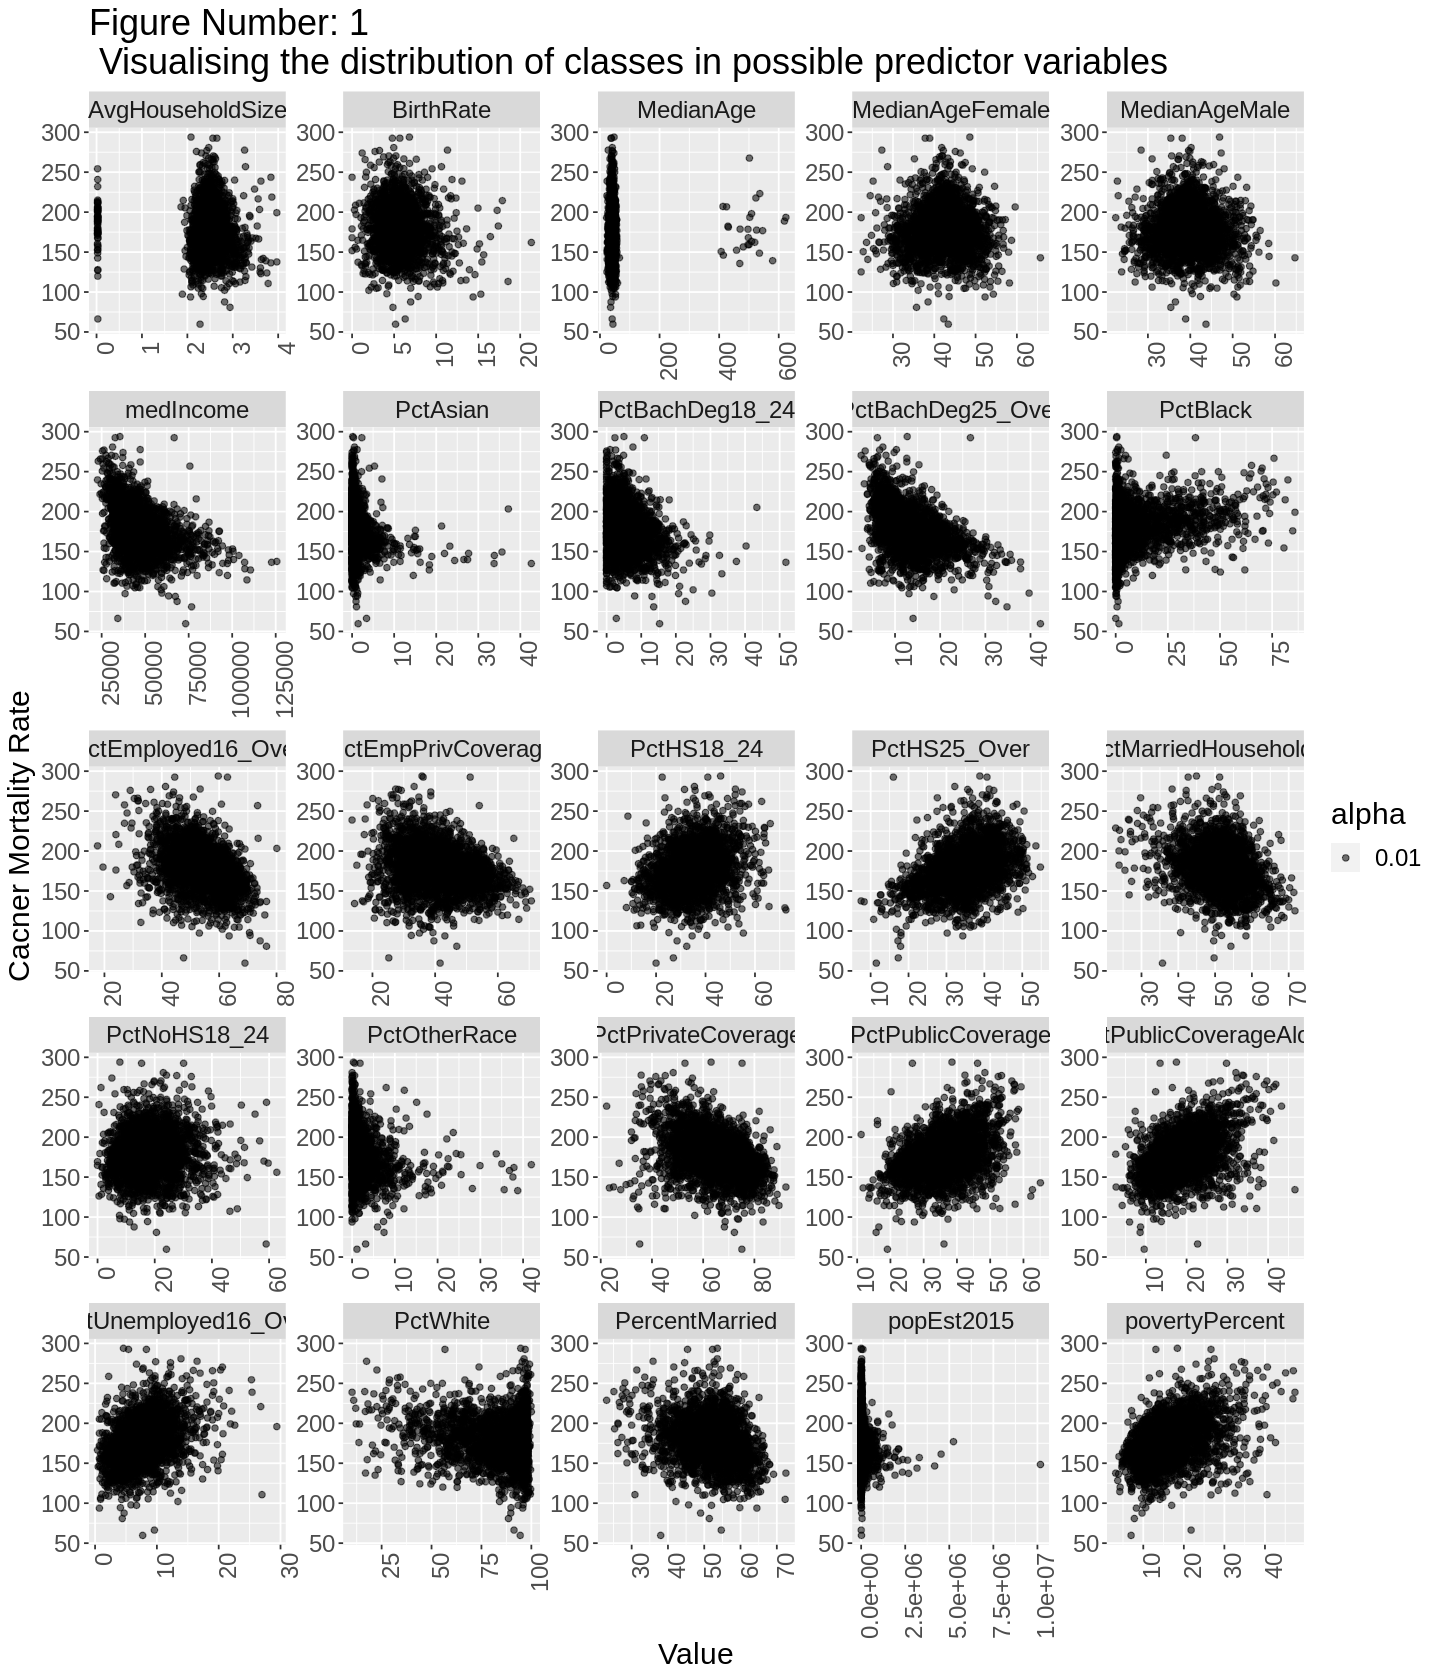

In [73]:
options(repr.plot.width = 12, repr.plot.height = 14)
paired_plot <- cancer_clean |>
    gather(key = "Predictor", value = "Value", -TARGET_deathRate) |>
    ggplot(aes(x = Value, y = TARGET_deathRate)) + #colouring the data points by the UNS column (which conatins the classes to be predicted)
    geom_point(aes(alpha = 0.01)) +
    ylab("Cacner Mortality Rate") +
    facet_wrap(~Predictor, scales = "free") +
    ggtitle("Figure Number: 1 \n Visualising the distribution of classes in possible predictor variables") +
    theme(text = element_text(size = 18)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) # adjusting the x-axis labels so they don't overlap wiht each other and are clearly visible

paired_plot

Looking at the last row of the panel above, we see how different predictors relate to the mortality rate of cancer patients.

###Note: Explain each plot

### Linear Regression Model

We now form our linear regression model usine the predictors: BirthRate, PctOtherRace, PctMarriedHouseholds, PctUnemployed16_Over and PctBachDeg25_Over.
                   

In [55]:
lm_spec <- linear_reg() |>
  set_engine("lm") |> #selecting linear regression
  set_mode("regression")

#making our recipe using the predictor we found by performing regsubsets()
lm_recipe_1 <- recipe(TARGET_deathRate ~ PctBachDeg25_Over, 
                   data = cancer_training) 

#making our recipe using the 2 predictors we found by performing regsubsets()
lm_recipe_2 <- recipe(TARGET_deathRate ~ PctMarriedHouseholds + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 3 predictors we found by performing regsubsets()
lm_recipe_3 <- recipe(TARGET_deathRate ~ PctOtherRace + PctMarriedHouseholds + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 4 predictors we found by performing regsubsets()
lm_recipe_4 <- recipe(TARGET_deathRate ~ PctOtherRace + PctMarriedHouseholds + PctUnemployed16_Over + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 5 predictors we found by performing regsubsets()
lm_recipe_5 <- recipe(TARGET_deathRate ~ BirthRate + PctOtherRace + PctMarriedHouseholds + PctUnemployed16_Over + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

lm_fit_1 <- workflow() |>
  add_recipe(lm_recipe_1) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_2 <- workflow() |>
  add_recipe(lm_recipe_2) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_3 <- workflow() |>
  add_recipe(lm_recipe_3) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_4 <- workflow() |>
  add_recipe(lm_recipe_4) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_5 <- workflow() |>
  add_recipe(lm_recipe_5) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

#testing the accuract of our model
lm_test_results_1 <- lm_fit_1 |>
  predict(cancer_testing) |>
  bind_cols(cancer_testing) |>
  metrics(truth = TARGET_deathRate, estimate = .pred)

lm_test_results_2 <- lm_fit_2 |>
  predict(cancer_testing) |>
  bind_cols(cancer_testing) |>
  metrics(truth = TARGET_deathRate, estimate = .pred)

lm_test_results_3 <- lm_fit_3 |>
  predict(cancer_testing) |>
  bind_cols(cancer_testing) |>
  metrics(truth = TARGET_deathRate, estimate = .pred)

lm_test_results_4 <- lm_fit_4 |>
  predict(cancer_testing) |>
  bind_cols(cancer_testing) |>
  metrics(truth = TARGET_deathRate, estimate = .pred)

lm_test_results_5 <- lm_fit_5 |>
  predict(cancer_testing) |>
  bind_cols(cancer_testing) |>
  metrics(truth = TARGET_deathRate, estimate = .pred)

In [56]:
lm_test_results_1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,24.5554670
rsq,standard,0.2139886
mae,standard,18.2910084


In [57]:
lm_test_results_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.9028483
rsq,standard,0.2574652
mae,standard,17.5751459


In [58]:
lm_test_results_3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.3025142
rsq,standard,0.2929037
mae,standard,17.1111963


In [59]:
lm_test_results_4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.3871014
rsq,standard,0.2915366
mae,standard,16.9863743


In [60]:
lm_test_results_5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.4660142
rsq,standard,0.2882836
mae,standard,17.1803625


### KNN Regression Model

In [61]:
knn_recipe_1 <- lm_recipe_1 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("regression")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(cancer_training, v = 5, strata = TARGET_deathRate)

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 5))

acc_1 <- workflow() |>
    add_recipe(knn_recipe_1) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_1 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_1 <- ggplot(acc_1, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
111,rmse,standard,23.80117,5,0.4351797,Preprocessor1_Model23


In [62]:
knn_recipe_2 <- lm_recipe_2 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_2 <- workflow() |>
    add_recipe(knn_recipe_2) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_2 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_2 <- ggplot(acc_2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
56,rmse,standard,22.80788,5,0.4463907,Preprocessor1_Model12


In [63]:
knn_recipe_3 <- lm_recipe_3 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_3 <- workflow() |>
    add_recipe(knn_recipe_3) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_3 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_3 <- ggplot(acc_3, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,22.05114,5,0.3882199,Preprocessor1_Model09


In [64]:
knn_recipe_4 <- lm_recipe_4 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_4 <- workflow() |>
    add_recipe(knn_recipe_4) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_4 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_4 <- ggplot(acc_4, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
51,rmse,standard,21.83306,5,0.3961528,Preprocessor1_Model11


In [65]:
knn_recipe_5 <- lm_recipe_5 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_5 <- workflow() |>
    add_recipe(knn_recipe_5) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_5 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_5 <- ggplot(acc_5, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,rmse,standard,21.76862,5,0.3538056,Preprocessor1_Model05


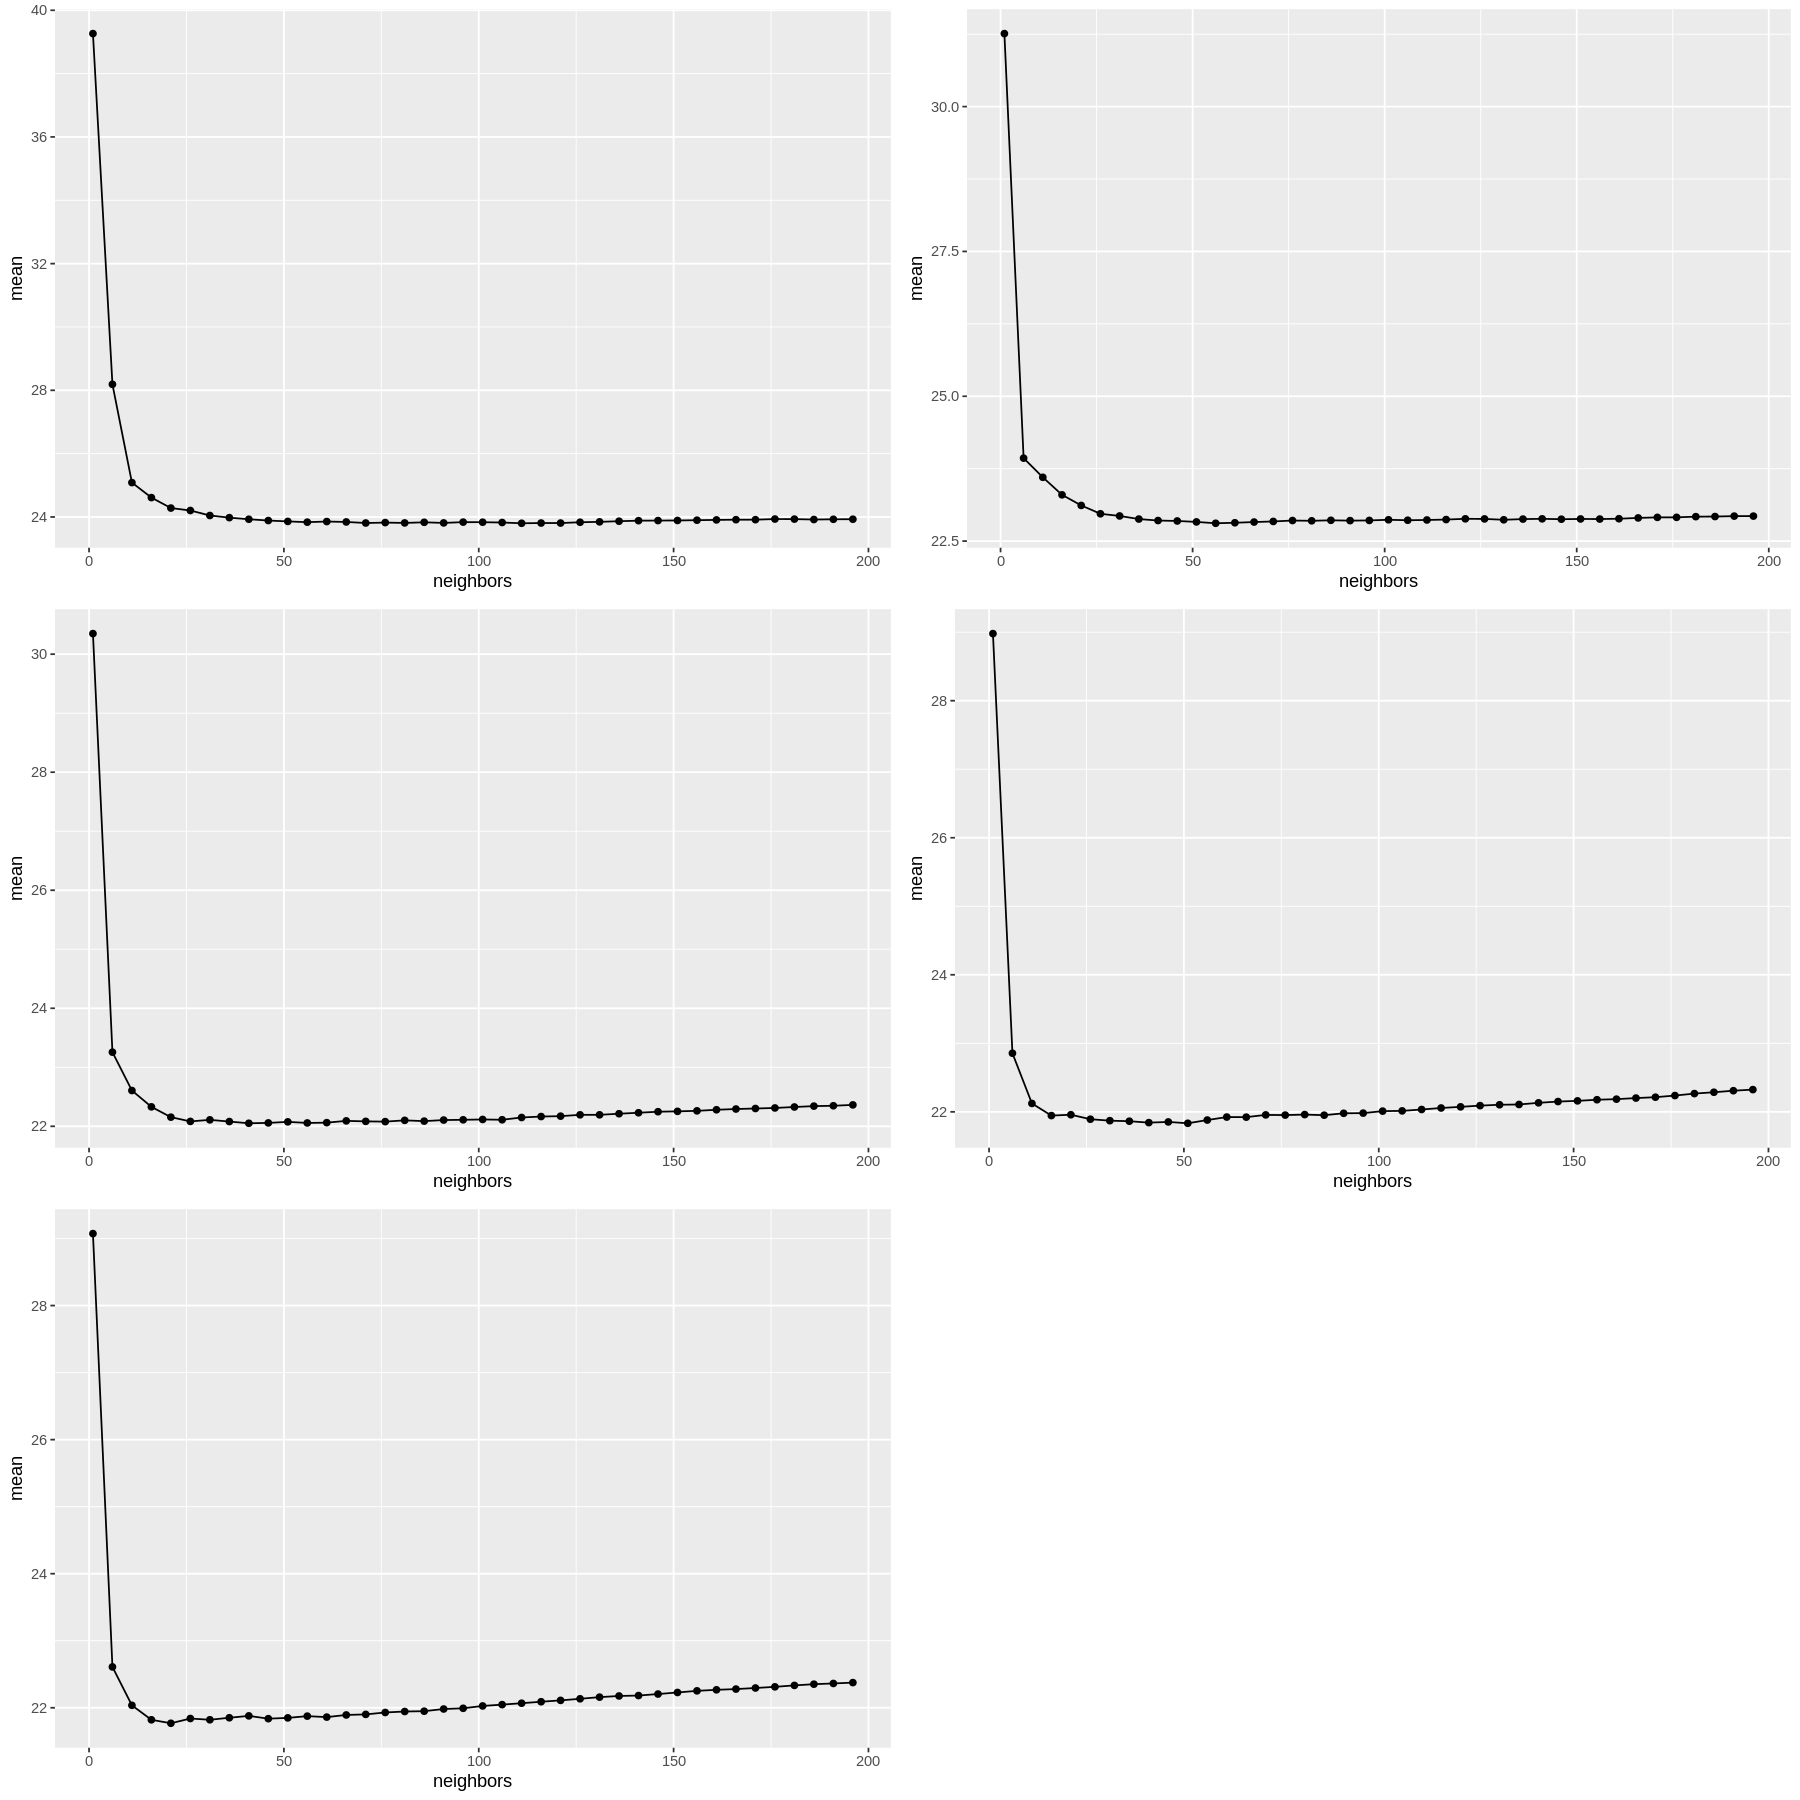

In [69]:
#visualizing all our plots 
options(repr.plot.width = 15, repr.plot.height = 15)
plot_grid(plot_1, plot_2, plot_3, plot_4, plot_5, ncol = 2)

In [67]:
knn_spec_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |>
     set_engine("kknn") |> #performing knn regression 
     set_mode("regression")

acc <- workflow() |>
    add_recipe(knn_recipe_4) |>
    add_model(knn_spec_4) |>
    fit(data = cancer_training)

predictions <- acc |>
    predict(cancer_testing) |>
    bind_cols(cancer_testing)

metrics_cancer <- metrics(predictions, truth = TARGET_deathRate, estimate = .pred) |>
    filter(.metric == "rmse")
metrics_cancer

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.89793


`geom_smooth()` using formula 'y ~ x'



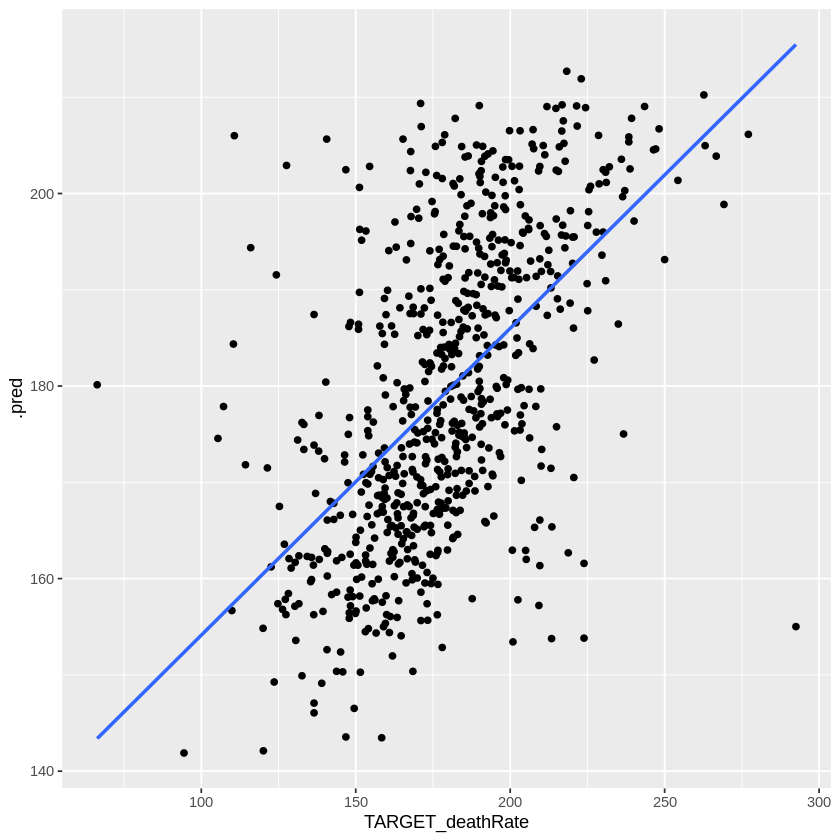

In [68]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(predictions, aes(x = TARGET_deathRate, y = .pred)) +
    geom_point() +
    geom_smooth(method = lm, se = FALSE)

### Visualizing Data

### Discussion


### Conclusion


### Sources cited
1. Albano, J. D., Ward, E., Jemal, A., Anderson, R., Cokkinides, V. E., Murray, T., Henley, J., Liff, J., & Thun, M. J. (2007). Cancer mortality in the United States by education level and race. JNCI: Journal of the National Cancer Institute, 99(18), 1384–1394. https://doi.org/10.1093/jnci/djm127 

2. Nelles, J. L., Joseph, S. A., & Konety, B. R. (2009). The impact of marriage on bladder cancer mortality. Urologic Oncology: Seminars and Original Investigations, 27(3), 263–267. https://doi.org/10.1016/j.urolonc.2008.04.016 

3. Gerdtham, U.-G., & Johannesson, M. (2003). A note on the effect of unemployment on mortality. Journal of Health Economics, 22(3), 505–518. https://doi.org/10.1016/s0167-6296(03)00004-3 

4. Barone, A., & Murry, C. (2022, May 28). Residual Sum of Squares (RSS): What It Is, How to Calculate It. Investopedia. Retrieved June 22, 2023, from https://www.investopedia.com/terms/r/residual-sum-of-squares.asp

5. Ruiz, E. F., Torres-Roman, J. S., Servan, S. A., Martinez-Herrera, J. F., Arce-Huamani, M. A., Carioli, G., & La Vecchia, C. (2019). Trends and geographic pattern of stomach cancer mortality in peru. Cancer Epidemiology, 58, 193-198. https://doi.org/10.1016/j.canep.2018.10.018
